# 2D Problem

In [1]:
# Import the FEMSystem Class from directory above
import sys
sys.path.append('..')
from FEMSystem import FEMSystem

# Remaining Imports
import jax.numpy as jnp
import skfem as fem
from jaxopt import LBFGS
import jax
import matplotlib.pyplot as plt

# Generate Mesh

In [2]:
import gmsh
import sys

gmsh.initialize()

# Create a gmsh "Model"
gmsh.model.add("t1")

def create_square(x,y,sidelen,lc):
    # Characteristic Length, to tune the mesh spacing
    gridlen = sidelen

    # Define Points
    t1 = gmsh.model.geo.addPoint(-gridlen/2 + x, -gridlen/2 + y, 0, lc)
    t2 = gmsh.model.geo.addPoint(gridlen/2 + x, -gridlen/2 + y, 0, lc)
    t3 = gmsh.model.geo.addPoint(gridlen/2 + x, gridlen/2 + y, 0, lc)
    t4 = gmsh.model.geo.addPoint(-gridlen/2 + x,gridlen/2 + y, 0, lc)

    centerpt = gmsh.model.geo.addPoint(x,y,0,lc*10)

    # Define Lines
    t1a = gmsh.model.geo.addLine(t1, t2)
    t2a = gmsh.model.geo.addLine(t3, t2)
    t3a = gmsh.model.geo.addLine(t3, t4)
    t4a = gmsh.model.geo.addLine(t4, t1)

    # Define a curve loop that is closed
    t1b = gmsh.model.geo.addCurveLoop([t4a, t1a, -t2a, t3a])

    return t1b
    
'''
DEFINE PARAMETER
'''

gridlen = 120
sideLen = 30
separation = 10
inner_dim = 20
mesh_file = "thismesh.msh"


lc_large,lc_small = 20,1

out_sq_loop = create_square(0,0,120,lc_large)
left_sq_loop = create_square(-(separation + sideLen)/2,0,sideLen,lc_small)
right_sq_loop = create_square((separation + sideLen)/2,0,sideLen,lc_small)

left_sq_loop_inner = create_square(-(separation + sideLen)/2,0,sideLen-inner_dim,lc_large)
right_sq_loop_inner = create_square((separation + sideLen)/2,0,sideLen-inner_dim,lc_large)

outer = gmsh.model.geo.addPlaneSurface([out_sq_loop,left_sq_loop,right_sq_loop])
left_outer = gmsh.model.geo.addPlaneSurface([left_sq_loop,left_sq_loop_inner])
right_outer = gmsh.model.geo.addPlaneSurface([right_sq_loop,right_sq_loop_inner])
left_inner = gmsh.model.geo.addPlaneSurface([left_sq_loop_inner]) 
right_inner = gmsh.model.geo.addPlaneSurface([right_sq_loop_inner]) 

gmsh.model.geo.synchronize()

# Generate mesh of dim 2
gmsh.model.mesh.generate(2)

# Write to file
gmsh.write(mesh_file)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 30%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 40%] Meshing curve 7 (Line)
Info    : [ 40%] Meshing curve 8 (Line)
Info    : [ 50%] Meshing curve 9 (Line)
Info    : [ 50%] Meshing curve 10 (Line)
Info    : [ 60%] Meshing curve 11 (Line)
Info    : [ 60%] Meshing curve 12 (Line)
Info    : [ 70%] Meshing curve 13 (Line)
Info    : [ 70%] Meshing curve 14 (Line)
Info    : [ 80%] Meshing curve 15 (Line)
Info    : [ 80%] Meshing curve 16 (Line)
Info    : [ 90%] Meshing curve 17 (Line)
Info    : [ 90%] Meshing curve 18 (Line)
Info    : [100%] Meshing curve 19 (Line)
Info    : [100%] Meshing curve 20 (Line)
Info    : Done meshing 1D (Wall 0.00112626s, CPU 0.001808s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 30%] Mes


Degrees of Freedom: 1479


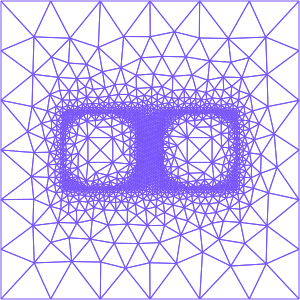

In [3]:
# Create the FEMSystem Object
# mesh = fem.MeshTri.init_sqsymmetric().refined(4)
mesh = fem.Mesh.load(mesh_file)

# L = 60.0
# mesh = mesh.scaled(2 * L).translated((-L, -L))
element = fem.ElementTriP1()
intorder = 3

femsystem = FEMSystem(mesh,element,intorder,boundary_condition=0)
print(f"Degrees of Freedom: {femsystem.dofs}")
mesh

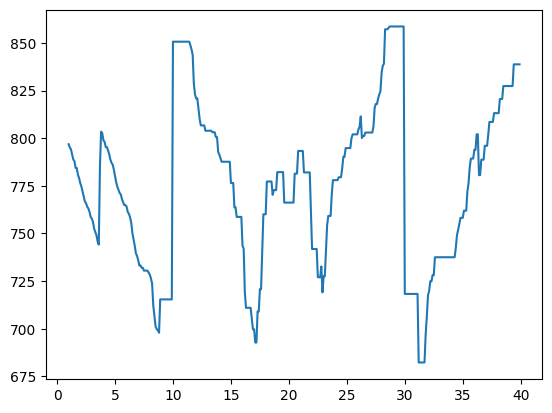

In [4]:
# Step 1: Define the Geometry of two rectangular islands:
seps = jnp.arange(1,40,0.1)
int_areas = []

for separation in seps:
    sideLen = 20
    centerLeft,centerRight = ((sideLen+separation)/2,0), (-(sideLen+separation)/2,0)
    area = 2 * (sideLen ** 2)

    def theta(x_vec):
        x,y = x_vec[0],x_vec[1]
        cond1 = (jnp.abs(x-centerLeft[0]) <= sideLen / 2) & (jnp.abs(y-centerLeft[1]) <= sideLen / 2)
        cond2 = (jnp.abs(x-centerRight[0]) <= sideLen / 2) & (jnp.abs(y-centerRight[1]) <= sideLen / 2)
        return cond1 | cond2

    def theta_right_only(x_vec):
        x,y = x_vec[0],x_vec[1]
        cond1 = (jnp.abs(x-centerLeft[0]) <= sideLen / 2) & (jnp.abs(y-centerLeft[1]) <= sideLen / 2)
        cond2 = (jnp.abs(x-centerRight[0]) <= sideLen / 2) & (jnp.abs(y-centerRight[1]) <= sideLen / 2)
        return cond1

    #femsystem.plot_func_2d(lambda a,b: theta([a,b]))
    #print(f"Area is {area}")
    # Now get integrated area. 
    theta_at_dofs = theta(femsystem.doflocs).astype(jnp.float32)
    integrated_area = femsystem.integrate(lambda u,grad_u,x: u,theta_at_dofs)
    int_areas.append(integrated_area)

   # print(f"Area Estimate: {integrated_area}")

plt.plot(seps,int_areas)

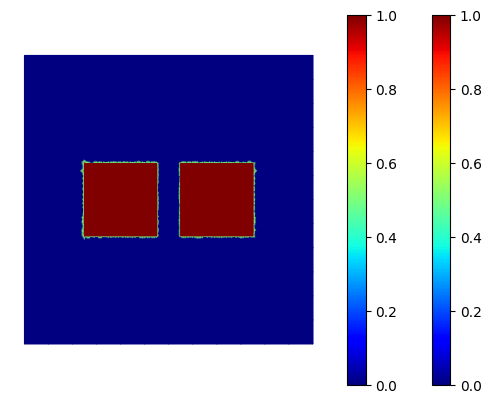

Area is 1800
Integrated Area Estimate: 1915.60791015625


In [5]:
sideLen = 30
separation = 10
centerLeft,centerRight = ((sideLen+separation)/2,0), (-(sideLen+separation)/2,0)
area = 2 * (sideLen ** 2)

def theta(x_vec):
    x,y = x_vec[0],x_vec[1]
    cond1 = (jnp.abs(x-centerLeft[0]) <= sideLen / 2) & (jnp.abs(y-centerLeft[1]) <= sideLen / 2)
    cond2 = (jnp.abs(x-centerRight[0]) <= sideLen / 2) & (jnp.abs(y-centerRight[1]) <= sideLen / 2)
    return cond1 | cond2

def theta_right_only(x_vec):
    x,y = x_vec[0],x_vec[1]
    cond1 = (jnp.abs(x-centerLeft[0]) <= sideLen / 2) & (jnp.abs(y-centerLeft[1]) <= sideLen / 2)
    cond2 = (jnp.abs(x-centerRight[0]) <= sideLen / 2) & (jnp.abs(y-centerRight[1]) <= sideLen / 2)
    return cond1

femsystem.plot_func_2d(lambda a,b: theta([a,b]))
print(f"Area is {area}")
# Now get integrated area. 
theta_at_dofs = theta(femsystem.doflocs).astype(jnp.float32)
integrated_area = femsystem.integrate(lambda u,grad_u,x: u,theta_at_dofs)
print(f"Integrated Area Estimate: {integrated_area}")

Vals: Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=1/0)>
Coeffs: Traced<ShapedArray(float32[50])>with<DynamicJaxprTrace(level=1/0)>
Plotting the Initial Guess


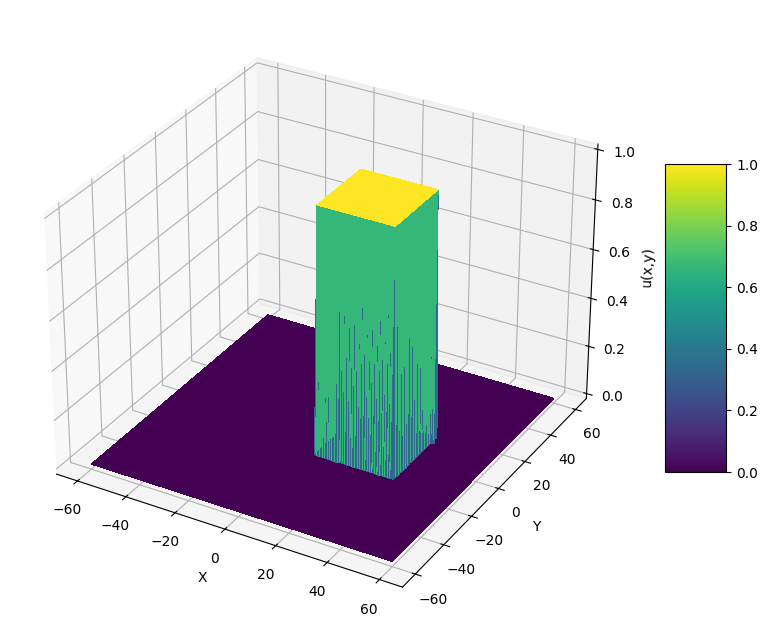

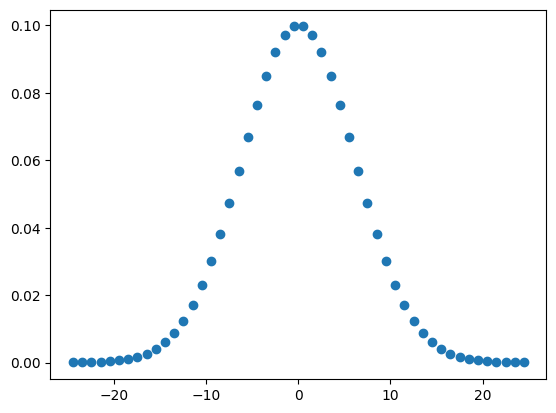

In [6]:
'''
Helper Functions for Integrals
'''

def laplacian(u,grad_u,x):
    return -1*jnp.sum(grad_u**2,axis=0)

# For Potential Energy Double Inetgral, u1 is our function phi_{+/-} and u2 is theta. 
def u_squared(u,grad_u,u2,grad_u2,x):
    return u**2

# Define Pre-Computed Values for Theta and Green's Function:
def theta_func(u,grad_u,u2,grad_u2,x):
    return u2

# U_{++++} or U_{----}, Really N * \alpha
def alpha(u,G_mat):
    return integrated_area  * femsystem.double_integral(lambda u1,a,b,c,d: u1**2,lambda u1,a,b,c,d: u1**2,G_mat,u,u)

# U_{+--+} = U{-++-} - Remember middle two are wrt to y, Outer two wrt to x, from notation used in doc
def beta(u1_arg,u2_arg,G_mat):
    return integrated_area * femsystem.double_integral(lambda u1,a,b,c,d: u1**2, lambda a,b,u2,c,d: u2**2, G_mat, u1_arg,u2_arg)

# U_{++--} = U{+-+-}
def gamma(u1_arg,u2_arg,G_mat):
    return integrated_area * femsystem.double_integral(lambda u1,a,u2,c,d: u1*u2, lambda u1,b,u2,c,d: u1*u2, G_mat, u1_arg,u2_arg)

'''
Helper Functions for Matrices
'''

def Sx(N):
    return Sz(N)

def Sy(N):
    return Sz(N) 

def Sz(N):
    j = (N-1)/2
    diagonals = j - jnp.arange(N)
    return jnp.diag(diagonals)

def offDiag(N):
    ones_super = jnp.ones(N - 1, dtype=jnp.int32)
    ones_sub = jnp.ones(N - 1, dtype=jnp.int32)
    super_diag_matrix = jnp.diag(ones_super, k=1)
    sub_diag_matrix = jnp.diag(ones_sub, k=-1)
    result = super_diag_matrix + sub_diag_matrix
    return result

def expval(mat,vec):
    return jnp.vdot(vec,mat @ vec)

def normalize_vec(vec):
    norm_v = jnp.linalg.norm(vec)
    # normalized_v = jnp.where(jnp.isclose(norm_v, 0.0), vec, vec / norm_v )
    return vec / norm_v

# get first N as the vector of coeffs, remaining as u_interior
def unpack(vec,N):
    coeff_vec,u = vec[:N],vec[N:]
    return coeff_vec,u

def guess_gaussian(N,stddevs=4):
    x = jnp.linspace(-stddevs, stddevs, N)
    mu,sigma = 0.0,1.0
    exponent = -jnp.square(x - mu) / (2.0 * jnp.square(sigma))
    gaussian_array = jnp.exp(exponent)
    return gaussian_array

# VERY VERY IMPORTANT TO PASS IN G_mat AS AN ARGUMENT, AND SET TO CONSTANT IN OPTIMIZATION LOOP
# This is because when JAX compiles this function, it will treat the G_mat as a "tracer", so just any matrix of constants with some shape. 
# If you hardcode it into the function, it will treat it as an actual part of the code and will spent time compiling a massive amount of hardcoded values as "code" essentially. This is why it takes almost 10 minutes to run first optimization iteration. 
# @jax.jit

def epsilon_func(u_global,G_mat,theta_at_dofs):
    # Kinetic Term
    kinetic = -4 * femsystem.integrate(laplacian,u_global)

    # Potential Term
    potential = -2 * femsystem.double_integral(u_squared,theta_func,G_mat,u_global,theta_at_dofs)

    return kinetic  + potential

def E(u_global,G_mat,theta_at_dofs):
    return epsilon_func(u_global,G_mat,theta_at_dofs) + alpha(u_global,G_mat)


'''
Before you start the optimization loop:
1. Define Objective
2. Compute Interaction Kernel
3. Get Initial Guess
'''

# Set constants
N = 50 # Number of coefficients. NOTE: Just set this to an outside variable. Lots of trouble trying to pass into a dynamical argument, since JAX doesn't like when array indices are dynamical. 

# 1. Defining Objective
@jax.jit
def objective(vec,G_mat,theta_at_dofs):
    # Unpack the modes from the coefficients
    coeff_vec,u_interior = unpack(vec,N)

    # Normalize Coeff Vector: 
    coeff_vec = normalize_vec(coeff_vec)

    # Unpack even and odd modes
    u_even,u_odd = femsystem.separate_even_odd_apply_by_and_norm(u_interior)
    E_plus,E_minus = E(u_even,G_mat,theta_at_dofs), E(u_odd,G_mat,theta_at_dofs)


    # Construct Objective
    zeropoint = (E_plus + E_minus) / 2
    hz = E_plus - E_minus
    spinZ = offDiag(N) / 5
    term1 = expval(spinZ,coeff_vec) * hz

    print("Vals:",zeropoint,term1)
    print("Coeffs:",coeff_vec)

    return zeropoint # + term1

# 2. Computing Interaction Kernel
epsilon = 1e-20
def G(x_vec,y_vec):
    # return 1 / jnp.sqrt(jnp.sum((x_vec-y_vec)**2,axis=-1)) + epsilon
    return - 1 / (2*jnp.pi) * jnp.log(jnp.sqrt(jnp.sum((x_vec-y_vec)**2,axis=-1)) + epsilon)

theta_at_dofs = theta(femsystem.doflocs)
G_mat = femsystem.get_sparse_interaction_mat(G)


# 2. Computing Interaction Kernel
# G_mat = femsystem.get_greens_kernel()

# 3. Getting Initial Guess
coeff_vector_init = guess_gaussian(N) / 10
u_interior_init = femsystem.ones_on_island(theta_right_only)
initial_guess = jnp.concatenate((coeff_vector_init, u_interior_init), axis=0)

'''
Testing, for a sanity check, and to do a jit compilation
'''
temp = objective(initial_guess,G_mat,theta_at_dofs)
print(f"Plotting the Initial Guess")
femsystem.plot_at_interior_2d_in3d(u_interior_init)
x = (N-1)/2 - jnp.arange(N)
plt.scatter(x,coeff_vector_init)

In [7]:
# Optimization Loop
print("Starting Optimization")
solver = LBFGS(fun=objective,tol=1e-2,verbose=True)
result = solver.run(initial_guess,G_mat,theta_at_dofs)
result = result.params 
coeffs,u_interior = unpack(result,N)

Starting Optimization


INFO: jaxopt.LBFGS: Iter: 1 Gradient Norm (stopping criterion): 0.28875312209129333 Objective Value:897.6688232421875  Stepsize:0.030955567955970764  Number Linesearch Iterations:4 
INFO: jaxopt.LBFGS: Iter: 2 Gradient Norm (stopping criterion): 0.25200387835502625 Objective Value:897.667236328125  Stepsize:0.7429336309432983  Number Linesearch Iterations:5 
INFO: jaxopt.LBFGS: Iter: 3 Gradient Norm (stopping criterion): 0.23673002421855927 Objective Value:897.6568603515625  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 4 Gradient Norm (stopping criterion): 0.30316609144210815 Objective Value:897.6497802734375  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 5 Gradient Norm (stopping criterion): 0.7337872385978699 Objective Value:897.6396484375  Stepsize:1.0  Number Linesearch Iterations:1 
INFO: jaxopt.LBFGS: Iter: 6 Gradient Norm (stopping criterion): 0.4013737142086029 Objective Value:897.6221923828125  Stepsize:1.0  Number Linesearc

: 

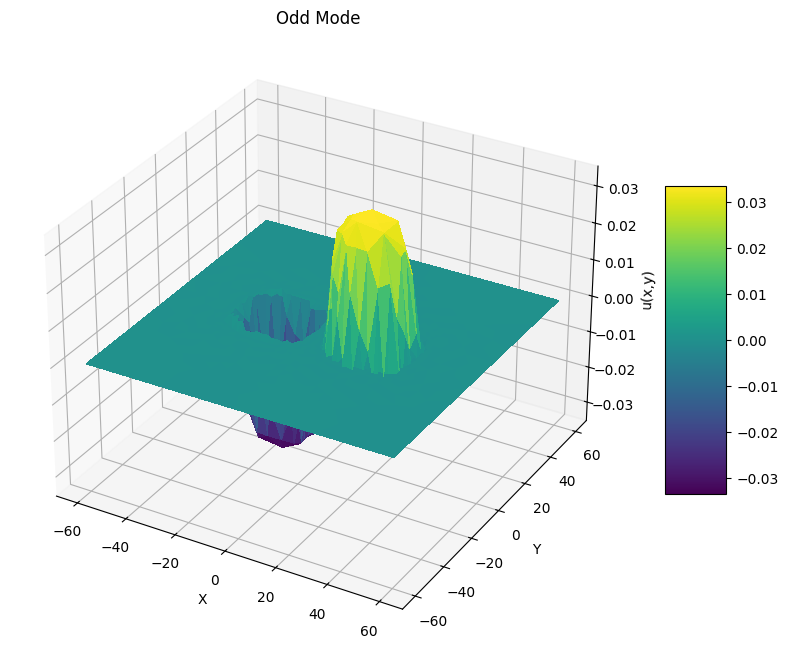

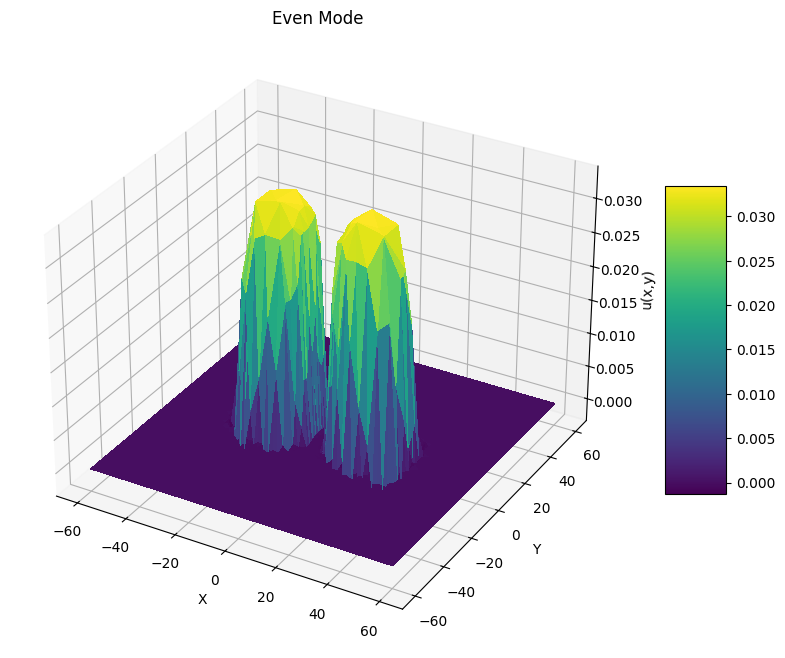

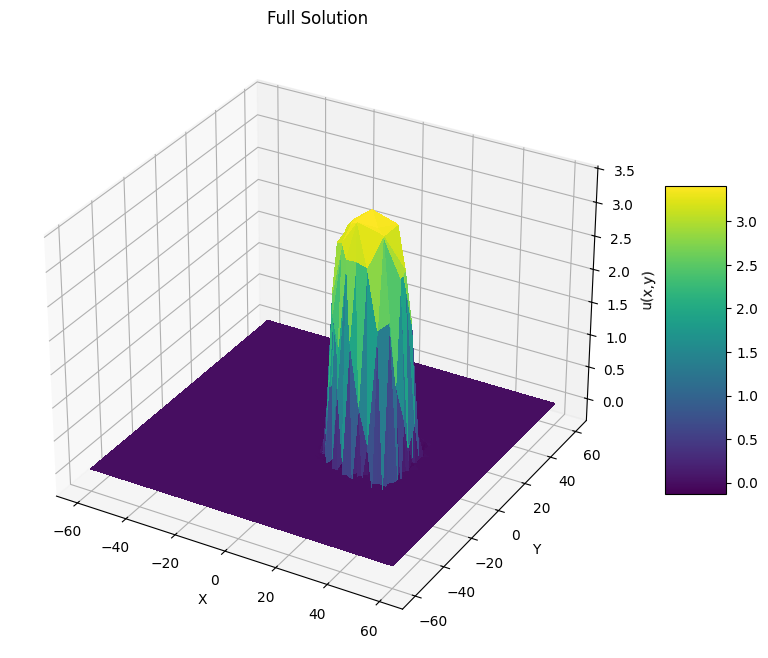

: 

In [ ]:
# Plot Solution

# Get Even and Odd Modes
u_even,u_odd = femsystem.separate_even_odd_apply_by_and_norm(u_interior)
u_even_interior,u_odd_interior = u_even[femsystem.interior_dofs],u_odd[femsystem.interior_dofs]

femsystem.plot_at_interior_2d_in3d(u_odd_interior,plot_title="Odd Mode")
femsystem.plot_at_interior_2d_in3d(u_even_interior,plot_title="Even Mode")
femsystem.plot_at_interior_2d_in3d(u_interior,plot_title="Full Solution")

In [ ]:
x = (N-1)/2 - jnp.arange(N)
plt.scatter(x,coeffs)

NameError: name 'N' is not defined

In [ ]:
lambda_y = 2*beta(u_even,u_odd,G_mat) - alpha(u_even,G_mat)- alpha(u_odd,G_mat)
print(lambda_y)